In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator
from matplotlib.legend_handler import HandlerTuple

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.metrics import eval_peak_distance, calculate_rms
from src.ForecastModel.utils.postprocessing import ModelHandler, get_n_peaks, dt

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})


In [2]:
PLOT_PATH          = r"hess_paper_output"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"models\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#ff7f00",
                ls = "-",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"models\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"models\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

## analyse peak events

In [4]:
num_peaks_per_fold    = 1     # number of peaks per fold to analyze
load_prev_predictions = False # load previous peak predictions or newly predict them

arima
extract peaks from model
dictonary loaded
extracting peaks from fold 0
extracting peaks from fold 1
extracting peaks from fold 2
extracting peaks from fold 3
extracting peaks from fold 4
processing fold 2
processing fold 3
processing fold 4
processing fold 5
processing fold 6
elstm
extract peaks from model
dictonary loaded
extracting peaks from fold 0
extracting peaks from fold 1
extracting peaks from fold 2
extracting peaks from fold 3
extracting peaks from fold 4
processing fold 2
processing fold 3
processing fold 4
processing fold 5
processing fold 6
pbhm-hlstm
extract peaks from model
dictonary loaded
extracting peaks from fold 0
35/35 [==============================] - 2s 6ms/step
extracting peaks from fold 1
35/35 [==============================] - 1s 13ms/step
extracting peaks from fold 2
35/35 [==============================] - 1s 11ms/step
extracting peaks from fold 3
35/35 [==============================] - 1s 12ms/step
extracting peaks from fold 4
35/35 [==============

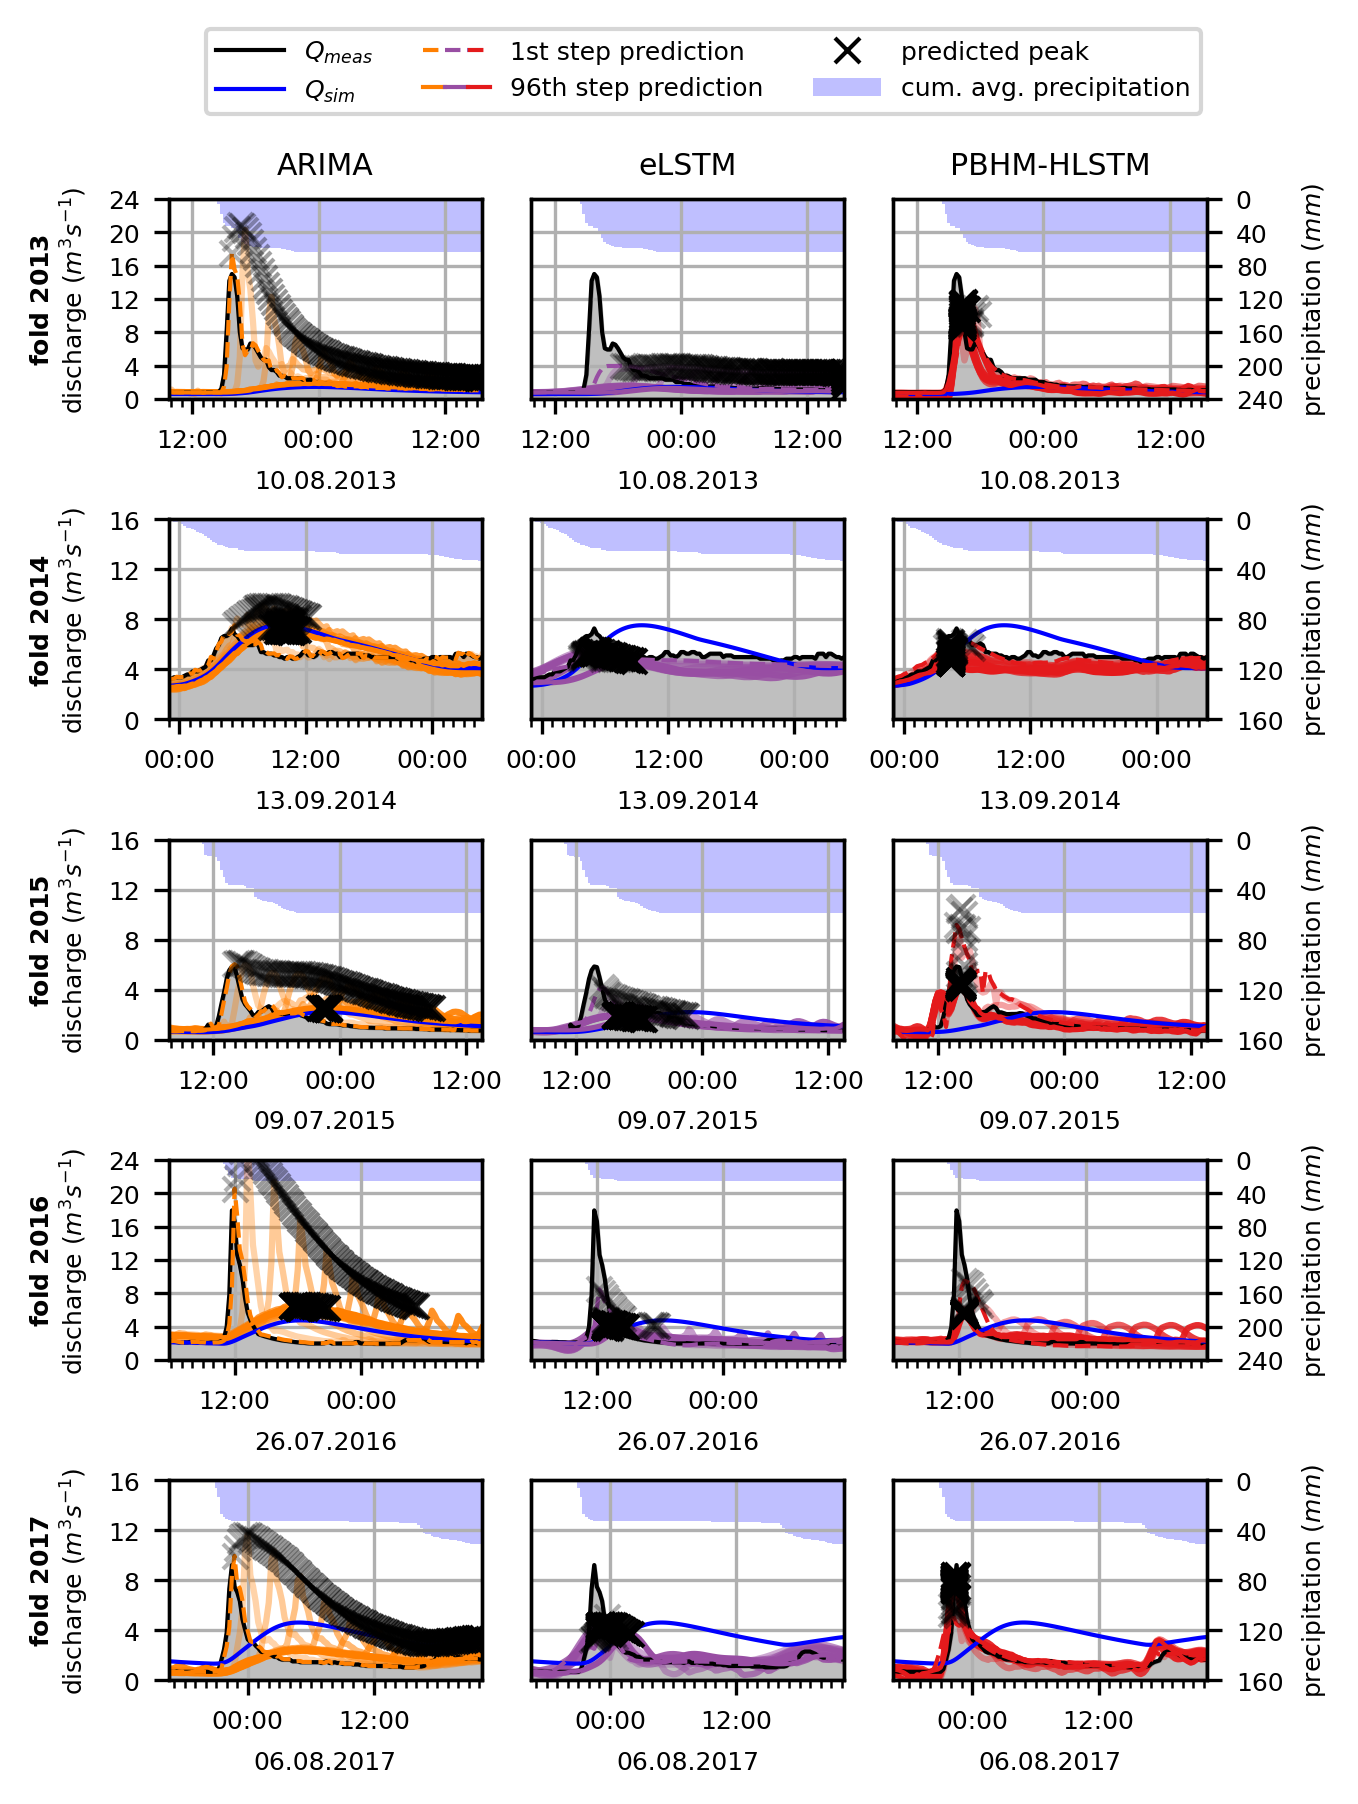

In [5]:
idx = -10
dfp = pd.DataFrame(columns = ["name", "year", "peak", 
                              "peak_flow", "total_flow",
                              "hyd_perr", "hyd_poff",
                              "rms_hyd", "flow_hyd", 
                              "rms_0", "rms_m", "rms_95",
                              "flow_0", "flow_m", "flow_95"]
                   
                        ) 
dfp = dfp.astype(dtype= {"name"     :"str",     "year"      :"int32",    "peak"  : "int32", 
                         "peak_flow":"float64", "total_flow":"float64",
                         "hyd_perr" :"float64", "hyd_poff"  :"float64",
                         "rms_hyd"  :"float64", "flow_hyd"  :"float64", 
                         "rms_0"    :"float64", "rms_m"     :"float64", "rms_95" : "float64",
                         "flow_0"   :"float64", "flow_m"    :"float64", "flow_95": "float64"}
                )

fig, axes = plt.subplots(5, 3, figsize=(4.72,6), dpi=300)
h_q0  = []
h_q95 = []
for n, key in enumerate(models.keys()):
    idx += 10
    print(key)
    eval_path = os.path.join(models[key].hp_path, "eval_peaks.pkl")
    
    if (not os.path.exists(eval_path)) | (load_prev_predictions == False):
        print("extract peaks from model")
        eval_peaks = []

        # load datamodel
        dm = DataModelCV(DATA_PATH,
               target_name       = models[key].target_name,
               hincast_features  = models[key].feat_hindcast,
               forecast_features = models[key].feat_forecast,
             )

        if models[key].is_external_model:
            overlap_length = 0
            hindcast_length = 96
        else:
            # load trial data
            with open(os.path.join(models[key].hp_path, "trial.json")) as f:
                trial = json.load(f)

            hindcast_length = trial['hyperparameters']['values']['hindcast_length']
            try:
                overlap_length = trial['hyperparameters']['values']['osc_length']
            except:
                overlap_length = 0 

        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

        for n_fold in dm.cross_sets.keys():
            print(f"extracting peaks from fold {n_fold}")
            year = 2013 + n_fold

            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

            # get hydrologial model 
            s = dm.getFeatureSet(n_fold+2, "qsim")[2]
            df = pd.DataFrame({'index':dt(s.index), 'qhyd':s.values}).set_index("index")

            # add ground truth
            s = dm.getFeatureSet(n_fold+2, "qmeasval")[2]
            s.index = dt(s.index)
            df = df.merge(s.rename("qmeas").to_frame(), left_index=True, right_index=True)

            if models[key].is_external_model:
                
                ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

                ext_df.index = pd.date_range(ext_df.index[0], ext_df.index[-1], freq="15min", tz="UTC")
                
                forecasts_df = ext_df[[f"fc{x:d}" for x in range(96)]].copy()
                forecasts_df.columns = [f"q{x:d}" for x in range(96)]

                del ext_df
                
            else:
                if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
                    forecasts_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))
                else:
                    # load model
                    tf.keras.backend.clear_session()
                    model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))
    
                    yp = model.predict(X, batch_size=1000)

                    forecasts_df = pd.DataFrame(data    = yp, 
                                        columns = [f"q{x:d}" for x in range(yp.shape[1])],
                                        index   = dt(dm.getTimeSet(n_fold+2, 0)[2]))

            # get forcasting stats                          
            for forecast_step in range(1, forecasts_df.shape[1]):
                forecasts_df[f"q{forecast_step:d}"] = forecasts_df[f"q{forecast_step:d}"].shift(forecast_step)
            
            # merge model predctions
            df = df.merge(forecasts_df, left_index=True, right_index=True)  
            
            # merge prcipitation
            s = pd.Series(dm.getFeatureSet(n_fold+2, "pmean", 0)[2].values, dt(dm.getTimeSet(n_fold+2, 0)[2]))
            df = df.merge(s.rename("pmean").to_frame(), left_index=True, right_index=True)
            
            forecasts_df.dropna(inplace=True)
            stats_df = pd.DataFrame(columns = ["fmin", "fmax", "fmean", 
                                               "fq95", "fq90", "fq75",
                                               "fq50",
                                               "fq25", "fq10", "fq5"],
                                   index = forecasts_df.index)
            
            for i, row in forecasts_df.iterrows():
                stats_df.loc[i] = [row.values.min(), row.values.max(), row.values.mean()] + \
                                        [np.quantile(row.values, float(x[2:])/100) for x in stats_df.columns[3:]]
                  
            # merge stats
            df = df.merge(stats_df, left_index=True, right_index=True)        
            df.dropna(inplace=True)
                                           
            peaks = get_n_peaks(df, "qmeas", num_peaks_per_fold, 24*4)
            peaks["n_fold"] = n_fold + 2

            # add to summary
            eval_peaks.append(peaks)

        # save data to pickle
        df = pd.concat(eval_peaks, axis=0)
        df.to_pickle(eval_path)

    df = pd.read_pickle(eval_path)
    for n_fold in df.n_fold.unique().tolist():
        print(f"processing fold {n_fold}")
        peaks = df[df.n_fold == n_fold]
        for p in range(num_peaks_per_fold):
            
            dt_index = pd.to_datetime(peaks[peaks.n_peak == p]["qmeas"].index, format="%d/%m/%Y %H:%M", utc=True)
            timestep = dt_index[1] - dt_index[0]
            
            axes[n_fold-2, n].grid("on")
            
            # add precipitation bars
            if n_fold-2 in [0,3]:
                offset_precip = 24
            else:
                offset_precip = 16
            h_precip = axes[n_fold-2, n].bar(dt_index, 
                                 - 0.1 * np.cumsum(peaks[peaks.n_peak == p]["pmean"].values.astype(np.float64)),
                                 timestep, offset_precip,
                                 label="cum. avg. precipitation",
                                 color= "b",
                                 alpha = 0.25,
                                 )
            axes2 = axes[n_fold-2, n].twinx()
            axes2.invert_yaxis()

            # eval peaks
            idx_peak  = peaks[peaks.n_peak == p]["qmeas"].argmax()
            peak_flow = peaks[peaks.n_peak == p]["qmeas"].max()
            dfp.loc[idx+n_fold+5*p, ["hyd_perr", "hyd_poff"]] = [peaks[peaks.n_peak == p]["qhyd"].max() - peak_flow,
                                                                 peaks[peaks.n_peak == p]["qhyd"].argmax() - idx_peak,
                                                                ]
            dfp.loc[idx+n_fold+5*p, [f"perr_{x}" for x in range(96)]] = [peaks[peaks.n_peak == p][f"q{x}"].max() - peak_flow for x in range(96)]
            dfp.loc[idx+n_fold+5*p, [f"poff_{x}" for x in range(96)]] = [peaks[peaks.n_peak == p][f"q{x}"].argmax() - idx_peak for x in range(96)]

            # eval section
            rms_q0 = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["q0"].values)
            rms_qm = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["fmean"].values)
            rms_q95 = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["q95"].values)
            rms_hyd = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["qhyd"].values)
            
            peak_flow = peaks[peaks.n_peak == p]["qmeas"].max()
            
            dfp.loc[idx+n_fold+5*p, ["name", "year", "peak"]] = [models[key].name, np.int32(2011+n_fold), np.int32(p)]
            dfp.loc[idx+n_fold+5*p, ["peak_flow", "total_flow"]] = [peak_flow, peaks[peaks.n_peak == p]["qmeas"].sum()]
            dfp.loc[idx+n_fold+5*p, ["rms_hyd", "flow_hyd"]] = [rms_hyd,  peaks[peaks.n_peak == p]["qhyd"].sum()]
            dfp.loc[idx+n_fold+5*p, ["rms_0", "rms_m", "rms_95"]] = [rms_q0, rms_qm, rms_q95]
            dfp.loc[idx+n_fold+5*p, ["flow_0", "flow_m", "flow_95"]] = [peaks[peaks.n_peak == p]["q0"].sum(),
                                                                     peaks[peaks.n_peak == p]["fmean"].sum(),
                                                                     peaks[peaks.n_peak == p]["q95"].sum(),
                                                                    ]
            
            axes[n_fold-2, n].fill_between(peaks[peaks.n_peak == p]["qmeas"].index, 
                                           peaks[peaks.n_peak == p]["qmeas"].values,
                                           alpha=0.25,
                                           color="black")
            
            for k in range(5,96,10):
                axes[n_fold-2, n].plot(peaks[peaks.n_peak == p][f"q{k:d}"],  
                                    color=models[key].color,
                                    alpha = 0.3 + 0.7*k/96)
                
            h_meas, = axes[n_fold-2, n].plot(peaks[peaks.n_peak == p]["qmeas"], color="k", #marker=".", 
                                           label="Qmeas", lw=1) 
            h_sim,  = axes[n_fold-2, n].plot(peaks[peaks.n_peak == p]["qhyd"],  color="b", 
                                           label="Qsim", ls="-", lw=1) 

            handle, = axes[n_fold-2, n].plot(peaks[peaks.n_peak == p]["q0"],  
                                   color=models[key].color, ls="--", 
                                   label="1st step prediction", lw=1)
            if n_fold-2 == 0:
                h_q0.append(handle)
            
            handle, = axes[n_fold-2, n].plot(peaks[peaks.n_peak == p]["q95"],  
                                   color=models[key].color, ls="-", 
                                   label="96th step prediction", lw=1) 
            if n_fold-2 == 0:
                h_q95.append(handle)
            
            for k in range(0,96,1):
                values  = peaks[peaks.n_peak == p][f"q{k:d}"]
                h_peaks,= axes[n_fold-2, n].plot(values.idxmax(), values.max(),
                                    marker = "x",
                                    ls = "None",
                                    color="k",
                                    alpha = 0.3 + 0.7*k/96)
                
            axes[n_fold-2, n].set_xlim((dt_index[0],dt_index[-1]))
            if n_fold-2 in [0, 3]:
                axes[n_fold-2, n].set_ylim(0,24)
                axes2.set_yticks(np.arange(240,-1,-40))
            else:
                axes[n_fold-2, n].set_ylim(0,16)
                axes2.set_yticks(np.arange(160,-1,-40))
            
            axes[n_fold-2, n].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,60)))
            
            axes[n_fold-2, n].xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,28,12)))
            axes[n_fold-2, n].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            
            axes[n_fold-2, n].yaxis.set_major_locator(FixedLocator(range(0,25,4)))
            
            axes[n_fold-2, n].set_xlabel(dt_index[96].strftime("%d.%m.%Y"))
            if n == 0:
                label = [r"$\bf{"+f"fold\ {2011 + n_fold}"+r"}$", "discharge ($m^3s^{-1}$)"]
                axes[n_fold-2, n].set_ylabel("\n".join(label))
            elif n == 2:
                axes2.set_ylabel("precipitation ($mm$)")

            if n_fold-2 == 0:
                 axes[n_fold-2, n].set_title(models[key].name)


            # remove ticks in center plots
            if n in [1, 2]:
                 axes[n_fold-2, n].tick_params(axis=u'y', which=u'both',length=0)
                 axes[n_fold-2, n].set_yticklabels([])
            
            if n in [0, 1]:
                 axes2.tick_params(axis=u'y', which=u'both',length=0)
                 axes2.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(top=0.89, right=0.85)

h_legend = [h_meas, h_sim, tuple(h_q0), tuple(h_q95), h_peaks, h_precip]
h_legend_names = ["$Q_{meas}$", "$Q_{sim}$", "1st step prediction", "96th step prediction", "predicted peak", "cum. avg. precipitation"]
axes[0,1].legend(h_legend, h_legend_names, handlelength=2.7,
                 handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
                 bbox_to_anchor=(0.55, 1.3), 
                 loc='lower center', ncol=3, 
                 borderaxespad=1)


In [6]:
fig.savefig(os.path.join(PLOT_PATH, f'figD1-largest_peak_per_year.png'), bbox_inches="tight")